In [76]:
import pandas as pd
import numpy as np
import sys
import pickle
import sqlite3
import os
from sklearn import ensemble
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [77]:
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355

# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

PROTON_MASS = 1.007276

In [78]:
# the level of intensity at which the detector is in saturation
SATURATION_INTENSITY = 3000

In [79]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    try:
        return ((_int_f/_int_f.sum()) * _mz_f).sum()
    except:
        print("exception in mz_centroid")
        return None

In [80]:
def estimate_target_coordinates(row_as_series, mz_estimator, scan_estimator, rt_estimator):
    sequence_estimation_attribs_s = row_as_series[['theoretical_mz','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','experiment_intensity_mean','experiment_intensity_std_dev']]
    sequence_estimation_attribs = np.reshape(sequence_estimation_attribs_s.values, (1, -1))  # make it 2D

    # estimate the raw monoisotopic m/z
    mz_delta_ppm_estimated = mz_estimator.predict(sequence_estimation_attribs)[0]
    theoretical_mz = sequence_estimation_attribs_s.theoretical_mz
    estimated_monoisotopic_mz = (mz_delta_ppm_estimated / 1e6 * theoretical_mz) + theoretical_mz

    # estimate the raw monoisotopic scan
    estimated_scan_delta = scan_estimator.predict(sequence_estimation_attribs)[0]
    experiment_scan_mean = sequence_estimation_attribs_s.experiment_scan_mean
    estimated_scan_apex = (estimated_scan_delta * experiment_scan_mean) + experiment_scan_mean

    # estimate the raw monoisotopic RT
    estimated_rt_delta = rt_estimator.predict(sequence_estimation_attribs)[0]
    experiment_rt_mean = sequence_estimation_attribs_s.experiment_rt_mean
    estimated_rt_apex = (estimated_rt_delta * experiment_rt_mean) + experiment_rt_mean

    return {"mono_mz":estimated_monoisotopic_mz, "scan_apex":estimated_scan_apex, "rt_apex":estimated_rt_apex}

In [81]:
# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    MAX_NUMBER_OF_SULPHUR_ATOMS = 3
    MAX_NUMBER_OF_PREDICTED_RATIOS = 6

    S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S0_r[1] = np.array([-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684])
    S0_r[2] = np.array([0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412])
    S0_r[3] = np.array([0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939])
    S0_r[4] = np.array([-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979])
    S0_r[5] = np.array([-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742])
    S0_r[6] = np.array([0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180])

    S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S1_r[1] = np.array([-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489])
    S1_r[2] = np.array([0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601])
    S1_r[3] = np.array([0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027])
    S1_r[4] = np.array([0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815])
    S1_r[5] = np.array([-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163])
    S1_r[6] = np.array([0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940])

    S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S2_r[1] = np.array([-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070])
    S2_r[2] = np.array([0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884])
    S2_r[3] = np.array([0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139])
    S2_r[4] = np.array([0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786])
    S2_r[5] = np.array([-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608])
    S2_r[6] = np.array([-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598])

    model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=np.ndarray)
    model_params[0] = S0_r
    model_params[1] = S1_r
    model_params[2] = S2_r

    ratio = None
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [82]:
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [83]:
experiment_name = 'dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(experiment_name)

In [84]:
run_name = '190719_Hela_Ecoli_1to1_01'

In [85]:
PERCOLATOR_MAPPING_FILE_NAME = '{}/percolator-output/percolator-idx-mapping.csv'.format(EXPERIMENT_DIR)

In [86]:
mapping_df = pd.read_csv(PERCOLATOR_MAPPING_FILE_NAME)

In [87]:
file_idx = mapping_df[mapping_df.run_name == run_name].iloc[0].percolator_idx

In [88]:
# set up the coordinate estimators directory
COORDINATE_ESTIMATORS_DIR = "{}/coordinate-estimators".format(EXPERIMENT_DIR)
if not os.path.exists(COORDINATE_ESTIMATORS_DIR):
    print("The coordinate estimators directory is required but doesn't exist: {}".format(COORDINATE_ESTIMATORS_DIR))

# load the sequence library
SEQUENCE_LIBRARY_DIR = "{}/sequence-library".format(EXPERIMENT_DIR)
SEQUENCE_LIBRARY_FILE_NAME = "{}/sequence-library.pkl".format(SEQUENCE_LIBRARY_DIR)
if not os.path.isfile(SEQUENCE_LIBRARY_FILE_NAME):
    print("The sequences library file doesn't exist: {}".format(SEQUENCE_LIBRARY_FILE_NAME))
else:
    library_sequences_df = pd.read_pickle(SEQUENCE_LIBRARY_FILE_NAME)
    print("loaded {} sequences from the library".format(len(library_sequences_df)))

loaded 30681 sequences from the library


In [89]:
# load the coordinate estimators
MZ_ESTIMATOR_MODEL_FILE_NAME = "{}/run-{}-{}-estimator.pkl".format(COORDINATE_ESTIMATORS_DIR, run_name, 'mz')
SCAN_ESTIMATOR_MODEL_FILE_NAME = "{}/run-{}-{}-estimator.pkl".format(COORDINATE_ESTIMATORS_DIR, run_name, 'scan')
RT_ESTIMATOR_MODEL_FILE_NAME = "{}/run-{}-{}-estimator.pkl".format(COORDINATE_ESTIMATORS_DIR, run_name, 'rt')

with open(MZ_ESTIMATOR_MODEL_FILE_NAME, 'rb') as file:
    mz_estimator = pickle.load(file)
with open(SCAN_ESTIMATOR_MODEL_FILE_NAME, 'rb') as file:
    scan_estimator = pickle.load(file)
with open(RT_ESTIMATOR_MODEL_FILE_NAME, 'rb') as file:
    rt_estimator = pickle.load(file)

In [90]:
library_sequences_for_this_run_df = library_sequences_df.copy()
library_sequences_for_this_run_df['file_idx'] = file_idx  # so we can distinguish between metrics for the same sequence-charge

In [91]:
# calculate the target coordinates
print("calculating the target coordinates for each sequence-charge")
library_sequences_for_this_run_df['target_coords'] = library_sequences_for_this_run_df.apply(lambda row: estimate_target_coordinates(row, mz_estimator, scan_estimator, rt_estimator), axis=1)

calculating the target coordinates for each sequence-charge


In [92]:
library_sequences_for_this_run_df.sort_values(by=['experiment_intensity_mean'], ascending=False, inplace=True)

In [119]:
row = library_sequences_for_this_run_df.iloc[20000]

In [120]:
row

sequence                                                  STGTETGSNINVNSELNPSTGNR
charge                                                                          2
theoretical_mz                                                            1175.05
experiment_scan_mean                                                      129.365
experiment_scan_std_dev                                                   2.82626
experiment_scan_peak_width                                                48.1178
experiment_rt_mean                                                         483.93
experiment_rt_std_dev                                                        2.86
experiment_rt_peak_width                                                   8.7461
experiment_intensity_mean                                                  106104
experiment_intensity_std_dev                                                22299
number_of_runs_identified                                                      20
q_value         

In [121]:
experiment_scan_peak_width = row.experiment_scan_peak_width
experiment_rt_peak_width = row.experiment_rt_peak_width
charge = row.charge
CONVERTED_DATABASE_NAME = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(EXPERIMENT_DIR, experiment_name, run_name)

In [122]:
coordinates_d = row.target_coords
mono_mz = coordinates_d['mono_mz']
scan_apex = coordinates_d['scan_apex']
rt_apex = coordinates_d['rt_apex']

In [123]:
# distance for looking either side of the scan and RT apex, based on the other times this sequence has been seen in this experiment
SCAN_WIDTH = experiment_scan_peak_width
RT_WIDTH = experiment_rt_peak_width

# the width to use for isotopic width, in Da
MZ_TOLERANCE_PPM = 5  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
MS1_PEAK_DELTA = mono_mz * MZ_TOLERANCE_PERCENT / 100

# the number of isotopes to look for in the m/z dimension - the theoretical model includes 7 (the monoisotopic plus 6 isotopes)
NUMBER_OF_ISOTOPES = 7
expected_spacing_mz = CARBON_MASS_DIFFERENCE / charge

# define the region we will look in for the feature
feature_region_mz_lower = mono_mz - MS1_PEAK_DELTA
feature_region_mz_upper = mono_mz + (NUMBER_OF_ISOTOPES * expected_spacing_mz) + MS1_PEAK_DELTA
scan_lower = scan_apex - (2 * SCAN_WIDTH)
scan_upper = scan_apex + (2 * SCAN_WIDTH)
rt_lower = rt_apex - (2 * RT_WIDTH)
rt_upper = rt_apex + (2 * RT_WIDTH)

# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
feature_region_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_type == {}".format(feature_region_mz_lower, feature_region_mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, FRAME_TYPE_MS1), db_conn)
db_conn.close()


In [124]:
len(feature_region_raw_points_df)

4020

In [125]:
# derive peaks for the monoisotopic and the isotopes
isotope_peaks_l = []
isotope_raw_points_l = []
for isotope_idx in range(NUMBER_OF_ISOTOPES):
    estimated_isotope_midpoint = mono_mz + (isotope_idx * expected_spacing_mz)
    isotope_mz_lower = estimated_isotope_midpoint - MS1_PEAK_DELTA
    isotope_mz_upper = estimated_isotope_midpoint + MS1_PEAK_DELTA
    isotope_raw_points_df = feature_region_raw_points_df[(feature_region_raw_points_df.mz >= isotope_mz_lower) & (feature_region_raw_points_df.mz <= isotope_mz_upper)].copy()
    # add the isotope's raw points to the list
    isotope_raw_points_l.append(isotope_raw_points_df)
    if len(isotope_raw_points_df) > 0:
        # centroid the raw points to get the peak for the isotope
        isotope_raw_points_a = isotope_raw_points_df[['mz','intensity']].values
        mz_cent = mz_centroid(isotope_raw_points_a[:,1], isotope_raw_points_a[:,0])
        summed_intensity = isotope_raw_points_a[:,1].sum()
    else:
        mz_cent = None
        summed_intensity = 0
    # add the peak to the list of isotopic peaks
    isotope_peaks_l.append((mz_cent, summed_intensity))
isotope_peaks_df = pd.DataFrame(isotope_peaks_l, columns=['mz_centroid','summed_intensity'])


In [126]:
isotope_peaks_df

,mz_centroid,summed_intensity
0,1175.050979,33206.0
1,1175.551076,37699.0
2,1176.051355,24467.0
3,1176.554777,13977.0
4,1177.056123,4590.0
5,1177.558282,596.0
6,NaN,0.0


In [127]:
len(isotope_raw_points_l)

7

In [128]:
s = pd.Series([0, mono_mz, 0, int(3200), 0], index=isotope_raw_points_l[0].columns)

In [129]:
# find the most intense isotope that is not in saturation
isotope_idx_not_in_saturation = -1
for isotope_idx in range(NUMBER_OF_ISOTOPES):
    isotope_df = isotope_raw_points_l[isotope_idx]
    if isotope_df.intensity.max() <= SATURATION_INTENSITY:
        isotope_idx_not_in_saturation = isotope_idx
        break

In [130]:
isotope_idx_not_in_saturation

0

In [106]:
isotope_raw_points_l[3].intensity.max()

3588

In [68]:
row

sequence                                                  SINPDEAVAYGAAVQAAILSGDK
charge                                                                          2
theoretical_mz                                                            1130.58
experiment_scan_mean                                                      93.6057
experiment_scan_std_dev                                                   9.42353
experiment_scan_peak_width                                                57.6692
experiment_rt_mean                                                        1004.73
experiment_rt_std_dev                                                     3.29174
experiment_rt_peak_width                                                   11.002
experiment_intensity_mean                                             1.86962e+06
experiment_intensity_std_dev                                          1.53483e+06
number_of_runs_identified                                                      20
q_value         

In [69]:
monoisotopic_mass = calculate_monoisotopic_mass_from_mz(row.theoretical_mz, row.charge)

In [70]:
monoisotopic_mass

2259.1382

In [71]:
isotope_peaks_df['adjusted_intensity'] = isotope_peaks_df.summed_intensity
isotope_peaks_df['adjusted_for_saturation'] = False

In [72]:
Hpn = isotope_peaks_df.iloc[isotope_idx_not_in_saturation].summed_intensity

In [73]:
# using as a reference the most intense isotope that is not in saturation, derive the isotope intensities back to the monoisotopic
for peak_number in reversed(range(1,isotope_idx_not_in_saturation+1)):
    print(peak_number)
    phr = peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur=0)
    Hpn_minus_1 = Hpn / phr
    isotope_peaks_df.loc[isotope_peaks_df.index == peak_number-1, 'adjusted_intensity'] = Hpn_minus_1
    isotope_peaks_df.loc[isotope_peaks_df.index == peak_number-1, 'adjusted_for_saturation'] = True
    Hpn = Hpn_minus_1

5
4
3
2
1


In [74]:
isotope_peaks_df

,mz_centroid,summed_intensity,adjusted_intensity,adjusted_for_saturation
0,1130.578349,2447266.0,1.874520e+06,True
1,1131.080031,2817676.0,2.290690e+06,True
2,1131.581029,1872001.0,1.510399e+06,True
3,1132.082188,827148.0,7.047271e+05,True
4,1132.582894,276063.0,2.585904e+05,True
5,1133.084192,79000.0,7.900000e+04,False
6,1133.585446,20755.0,2.075500e+04,False


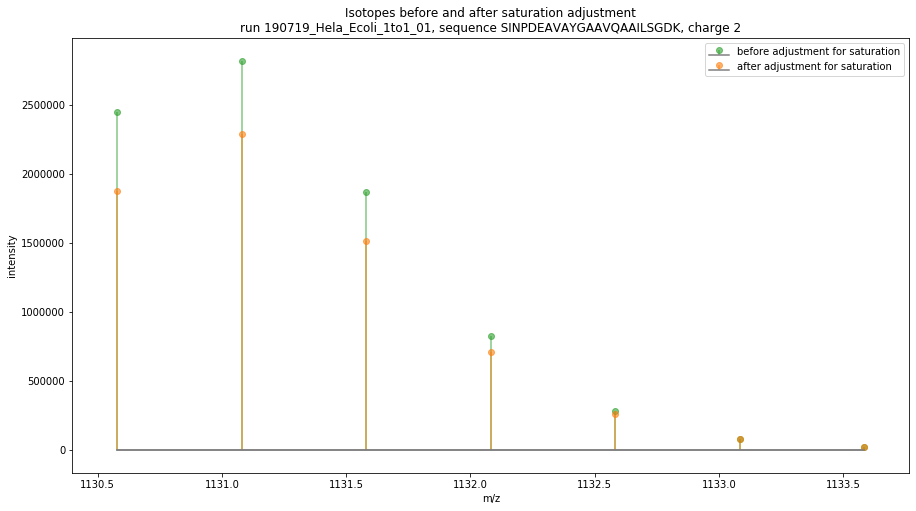

In [75]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(isotope_peaks_df.mz_centroid, isotope_peaks_df.summed_intensity, use_line_collection=True, label='before adjustment for saturation')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

markerline, stemlines, baseline = ax.stem(isotope_peaks_df.mz_centroid, isotope_peaks_df.adjusted_intensity, use_line_collection=True, label='after adjustment for saturation')
plt.setp(markerline, 'color', 'tab:orange')
plt.setp(stemlines, 'color', 'tab:orange')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)
plt.legend(loc='best')
plt.title('Isotopes before and after saturation adjustment\nrun {}, sequence {}, charge {}'.format(run_name, row.sequence, row.charge))
plt.show()